In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import polars as pl
import polars.selectors as cs
from typing import get_args

from data import load_data
from config import Species, TARGET, FEATURES_METADATA

# Load data for the given species
df = pl.concat([load_data(species) for species in get_args(Species)], how="vertical")

In [7]:
print("Number of rows in total:", df.height)
height = df.filter(pl.any_horizontal(cs.starts_with("dep_").is_not_null())).height
print("Number of rows with defoliation data:", height)
height = df.filter(pl.any_horizontal(cs.starts_with("ss_").is_not_null())).height
print("Number of rows with soil solution data:", height)

Number of rows in total: 33450
Number of rows with defoliation data: 28930
Number of rows with soil solution data: 20505


In [8]:
with pl.Config(
    tbl_formatting="MARKDOWN",
    tbl_hide_column_data_types=True,
    tbl_rows=-1,
    tbl_width_chars=200,
    fmt_str_lengths=200,
) as cfg:
    print(
        pl.from_dicts(
            [
                {**{"feature": feature}, **descr}
                for feature, descr in FEATURES_METADATA.items()
            ]
        )
    )

shape: (63, 5)
| feature             | description                                  | label                      | level | unit    |
|---------------------|----------------------------------------------|----------------------------|-------|---------|
| defoliation_max     | Maximum defoliation of the growth period     | Max defoliation            | tree  | %       |
| defoliation_min     | Minimum defoliation of the growth period     | Min defoliation            | tree  | %       |
| defoliation_mean    | Mean defoliation of the growth period        | Mean defoliation           | tree  | %       |
| defoliation_median  | Median defoliation of the growth period      | Median defoliation         | tree  | %       |
| social_class_min    | Minimum social class of the growth period    | Min. social class          | tree  | null    |
| plot_slope          | Slope of the plot                            | Plot slope                 | plot  | %       |
| plot_orientation    | Orientation of th

In [9]:
# Compare absolute growth, growth rate, and relative growth rate (to diameter)
df.select("growth", "growth_rate", "growth_rate_rel").describe()

statistic,growth,growth_rate,growth_rate_rel
str,f64,f64,f64
"""count""",33450.0,33450.0,33450.0
"""null_count""",0.0,0.0,0.0
"""mean""",1.306748,0.272147,0.009435
"""std""",0.937185,0.195,0.007257
"""min""",0.0,0.0,0.0
"""25%""",0.7,0.139484,0.004738
"""50%""",1.2,0.240033,0.008039
"""75%""",1.8,0.365982,0.012274
"""max""",21.0,4.103933,0.098348


In [10]:
# Check that data contains all features
missing_features = set(FEATURES_METADATA.keys()) - set(df.columns)
if missing_features:
    raise ValueError(
        f"Data is missing the following features: {missing_features}. "
        "Please check the data loading process."
    )

Distribution of the number of trees per plot:
# min = 1
# max = 759
# mean = 97.80701754385964
# of single-tree plots = 4


Text(0.5, 1.0, 'Distribution of the number of trees per plot')

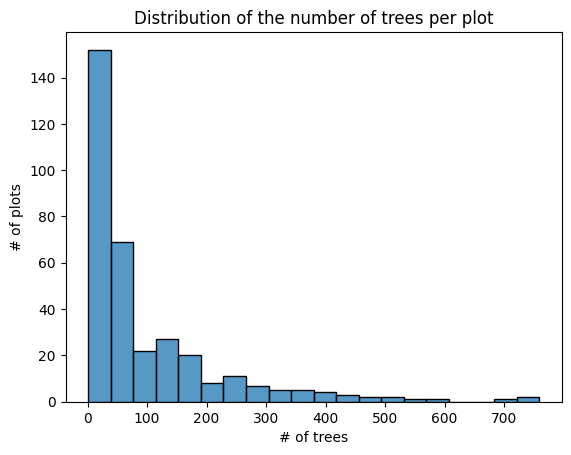

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of the number of trees per plot
print("Distribution of the number of trees per plot:")
num_trees = df.group_by("plot_id").agg(pl.count("tree_id").alias("num_trees"))

print(f"# min = {num_trees['num_trees'].min()}")
print(f"# max = {num_trees['num_trees'].max()}")
print(f"# mean = {num_trees['num_trees'].mean()}")
print(f"# of single-tree plots = {len(num_trees.filter(num_trees['num_trees'] == 1))}")

_ = sns.histplot(num_trees["num_trees"], bins=20)
plt.xlabel("# of trees")
plt.ylabel("# of plots")
plt.title("Distribution of the number of trees per plot")

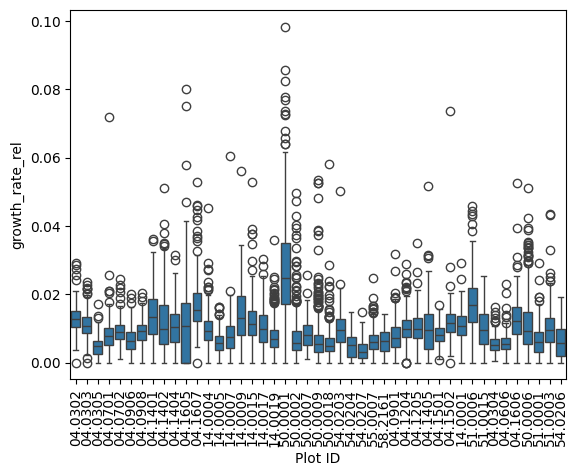

In [12]:
# Plot box plots of target variable by plot_id

# Keep only plots with at least 10 trees
data = df.with_columns(
    pl.col("tree_id").n_unique().over("plot_id").alias("num_trees")
).filter(pl.col("num_trees") >= 100)
sns.boxplot(x="plot_id", y=TARGET, data=data.to_pandas())
plt.xlabel("Plot ID")

# Vertical label for x-axis
_ = plt.xticks(rotation=90)

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'East'),
  Text(1, 0, 'Flat'),
  Text(2, 0, 'North'),
  Text(3, 0, 'North-east'),
  Text(4, 0, 'North-west'),
  Text(5, 0, 'South'),
  Text(6, 0, 'South-east'),
  Text(7, 0, 'South-west'),
  Text(8, 0, 'West')])

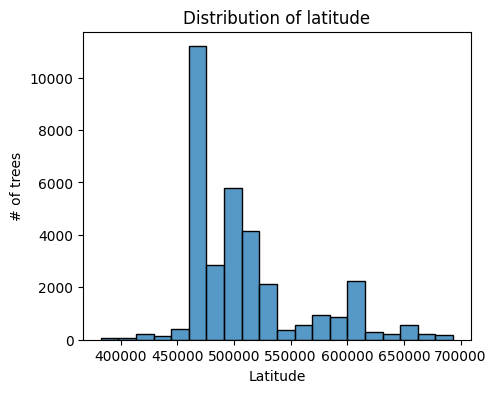

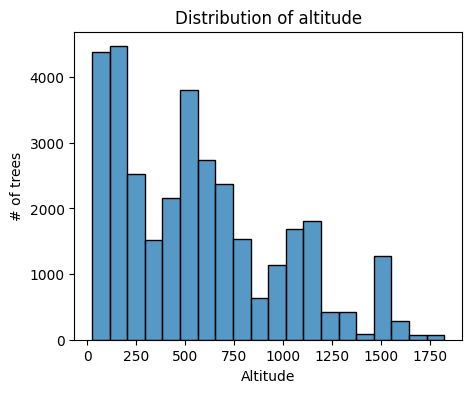

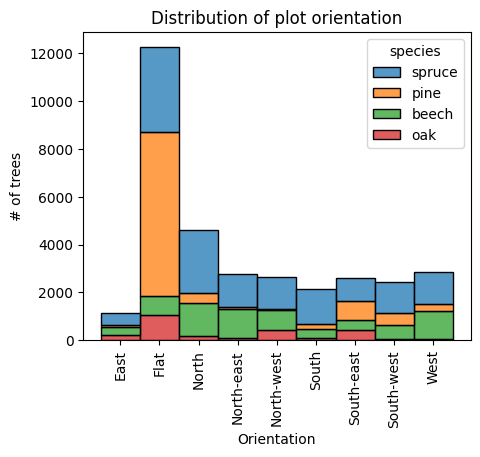

In [13]:
# Plot distribution of trees of latitude and longitude
plt.figure(figsize=(5, 4))
sns.histplot(df["plot_latitude"], bins=20)
plt.xlabel("Latitude")
plt.ylabel("# of trees")
plt.title("Distribution of latitude")

# Plot distribution of trees of altitudes
plt.figure(figsize=(5, 4))
sns.histplot(df["plot_altitude"], bins=20)
plt.xlabel("Altitude")
plt.ylabel("# of trees")
plt.title("Distribution of altitude")

# Plot distributions of trees across plot orientation for each species
plt.figure(figsize=(5, 4))
sns.histplot(
    data=df.to_pandas(),
    x="plot_orientation",
    bins=20,
    hue="species",
    multiple="stack",
    stat="count",
)
plt.xlabel("Orientation")
plt.ylabel("# of trees")
plt.title("Distribution of plot orientation")
plt.xticks(rotation=90)

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'East'),
  Text(1, 0, 'Flat'),
  Text(2, 0, 'North'),
  Text(3, 0, 'North-east'),
  Text(4, 0, 'North-west'),
  Text(5, 0, 'South'),
  Text(6, 0, 'South-east'),
  Text(7, 0, 'South-west'),
  Text(8, 0, 'West')])

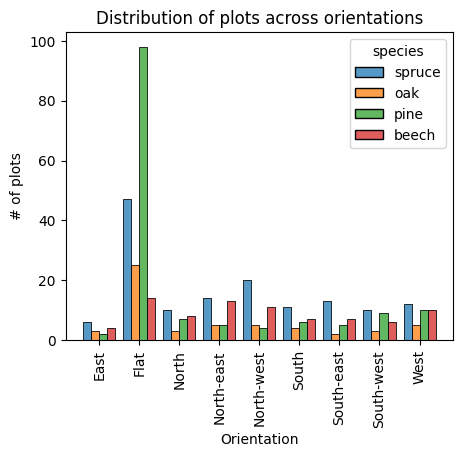

In [14]:
# plot distribution of plots across orientations
plt.figure(figsize=(5, 4))
sns.histplot(
    data=df.group_by("species", "plot_id").agg(
        pl.first("plot_orientation").alias("plot_orientation")
    ),
    x="plot_orientation",
    bins=20,
    hue="species",
    multiple="dodge",
    shrink=0.8,
)
plt.xlabel("Orientation")
plt.ylabel("# of plots")
plt.title("Distribution of plots across orientations")
plt.xticks(rotation=90)

In [41]:
df.filter(pl.col("species") == "oak").filter(
    pl.col("dep_ph").is_between(5.25, 5.33)
).select(
    pl.col("plot_id"),
    pl.col("country"),
    pl.col("plot_latitude"),
    pl.col("plot_longitude"),
).unique()

plot_id,country,plot_latitude,plot_longitude
str,cat,i64,i64
"""14.0002""","""Austria""",472900,163300
"""04.1406""","""Germany""",511100,124900
"""14.0007""","""Austria""",473800,160800


In [36]:
df.filter(pl.col("species") == "oak").filter(pl.col("dep_ph") > 5.33).select(
    pl.col("growth_rate_rel").mean(), pl.col("plot_id").n_unique()
)

growth_rate_rel,plot_id
f64,u32
0.009142,41
